In [1]:
!pip -q install segmentation-models-pytorch==0.3.3 --no-deps
!pip -q install timm==0.9.2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 33.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
!pip install pretrainedmodels


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=d89421cf7a32c771907d49d2ffe5a4bc421bd6edfa1c00b0aaf52611b799b455
  Stored in directory: /root/.cache/pip/wheels/5f/5b/96/fd94bc35962d7c6b699e8814db545155ac91d2b95785e1b035
Successfully built pretrainedmodels
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
segmentation-models-pytorch 0.3.3 requires efficientnet-pytorch==0.7.1, which is not installed.


In [5]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16426 sha256=a0f07a61bfc7065cc01500d10cb40b306046d4aca4d3846cf036a47c1d40b33a
  Stored in directory: /root/.cache/pip/wheels/8b/6f/9b/231a832f811ab6ebb1b32455b177ffc6b8b1cd8de19de70c09
Successfully built efficientnet_pytorch


In [6]:
import os
import math
import random
import numpy as np
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

import segmentation_models_pytorch as smp
import timm

# =============== Config ===============
SEED = 42
NUM_CLASSES = 104            # FoodSeg103 classes
IGNORE_INDEX = 255
IMG_SIZE = 416               # Balanced speed/quality
BATCH_SIZE = 8               # Adjust if VRAM allows
ACCUM_STEPS = 2              # Gradient accumulation to simulate larger batch
NUM_EPOCHS = 25
LR = 6e-4                    # Head LR (decoder), encoder LR will be lower
WEIGHT_DECAY = 1e-4
ROOT_DIR = "/kaggle/input/foodseg103/FoodSeg103"  # Adjust if needed
TRAIN_SPLIT = "train"
VAL_SPLIT = "test"           # FoodSeg103 uses 'test' as the official val split
SAVE_BEST_PATH = "best_deeplabv3plus_mobilenetv2.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =============== Reproducibility ===============
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False

set_seed()


In [13]:
class FoodSegDataset(Dataset):
    def __init__(self, root_dir, split="train", img_size=IMG_SIZE, augment=True):
        self.root_dir = root_dir
        self.split = split
        self.img_size = img_size
        self.augment = augment and (split == "train")

        # Resolve paths
        candidates = [
            (os.path.join(root_dir, "FoodSeg103", "Images", "img_dir", split),
             os.path.join(root_dir, "FoodSeg103", "Images", "ann_dir", split),
             os.path.join(root_dir, "FoodSeg103", "ImageSets", f"{split}.txt")),
            (os.path.join(root_dir, "Images", "img_dir", split),
             os.path.join(root_dir, "Images", "ann_dir", split),
             os.path.join(root_dir, "ImageSets", f"{split}.txt")),
            (os.path.join(root_dir, split, "img_dir"),
             os.path.join(root_dir, split, "ann_dir"),
             os.path.join(root_dir, "ImageSets", f"{split}.txt")),
        ]
        for img_dir, ann_dir, id_file in candidates:
            if os.path.exists(img_dir) and os.path.exists(ann_dir):
                self.img_dir, self.ann_dir, self.id_file = img_dir, ann_dir, id_file
                break
        else:
            raise FileNotFoundError("Could not locate FoodSeg103 directories.")

        # IDs
        if self.id_file and os.path.exists(self.id_file):
            with open(self.id_file, "r") as f:
                self.ids = [line.strip() for line in f if line.strip()]
        else:
            self.ids = [os.path.splitext(f)[0]
                        for f in os.listdir(self.img_dir)
                        if f.lower().endswith((".jpg", ".png", ".jpeg"))]

        # Transforms
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])

    def __len__(self):
        return len(self.ids)

    def _load_image(self, img_id):
       base_id, ext = os.path.splitext(img_id)
       candidates = [img_id] if ext else [base_id + e for e in [".jpg", ".png", ".jpeg"]]
       for fname in candidates:
           path = os.path.join(self.img_dir, fname)
           if os.path.exists(path):
               return Image.open(path).convert("RGB")
       raise FileNotFoundError(f"Image not found for id {img_id}")

    def _load_mask(self, img_id):
       base_id, ext = os.path.splitext(img_id)
       candidates = [base_id + e for e in [".png", ".jpg"]]
       for fname in candidates:
           path = os.path.join(self.ann_dir, fname)
           if os.path.exists(path):
               return Image.open(path)
       raise FileNotFoundError(f"Mask not found for id {img_id}")


    def _augment(self, img, mask):
        # Lightweight augmentations
        if random.random() < 0.5:
            img = transforms.functional.hflip(img)
            mask = transforms.functional.hflip(mask)
        if random.random() < 0.3:
            angle = random.uniform(-10, 10)
            img = transforms.functional.rotate(img, angle, fill=0)
            mask = transforms.functional.rotate(mask, angle,
                interpolation=transforms.InterpolationMode.NEAREST, fill=IGNORE_INDEX)
        if random.random() < 0.3:
            jitter = transforms.ColorJitter(0.2, 0.2, 0.2, 0.05)
            img = jitter(img)
        return img, mask

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img = self._load_image(img_id)
        mask = self._load_mask(img_id)

        # Resize
        img = transforms.functional.resize(img, (self.img_size, self.img_size), antialias=True)
        mask = transforms.functional.resize(mask, (self.img_size, self.img_size),
                                            interpolation=transforms.InterpolationMode.NEAREST)

        # Augment
        if self.augment:
            img, mask = self._augment(img, mask)

        # To tensor and normalize
        img = self.to_tensor(img)
        img = self.normalize(img)

        mask = torch.from_numpy(np.array(mask, dtype=np.int64)).long()
        return img, mask


In [14]:
train_ds = FoodSegDataset(ROOT_DIR, split=TRAIN_SPLIT, img_size=IMG_SIZE, augment=True)
val_ds   = FoodSegDataset(ROOT_DIR, split=VAL_SPLIT,   img_size=IMG_SIZE, augment=False)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=4, pin_memory=True,
                          persistent_workers=True, prefetch_factor=3)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE*2, shuffle=False,
                          num_workers=4, pin_memory=True,
                          persistent_workers=True, prefetch_factor=3)

print(f"Train samples: {len(train_ds)} | Val samples: {len(val_ds)}")
print(f"Train batches: {len(train_loader)} | Val batches: {len(val_loader)}")


Train samples: 4983 | Val samples: 2135
Train batches: 623 | Val batches: 134


In [15]:
# DeepLabv3+ with MobileNetV2 backbone
# activation=None for logits; we’ll use CrossEntropyLoss with ignore_index
model = smp.DeepLabV3Plus(
    encoder_name="mobilenet_v2",
    encoder_weights="imagenet",  # pretrained backbone
    in_channels=3,
    classes=NUM_CLASSES,
    activation=None
).to(DEVICE)

# Separate encoder/decoder param groups for differential LR
encoder_params = []
decoder_params = []
for name, param in model.named_parameters():
    if not param.requires_grad:
        continue
    if name.startswith("encoder."):
        encoder_params.append(param)
    else:
        decoder_params.append(param)

optimizer = optim.AdamW([
    {"params": encoder_params, "lr": LR * 0.25, "weight_decay": WEIGHT_DECAY},  # smaller LR for encoder
    {"params": decoder_params, "lr": LR, "weight_decay": WEIGHT_DECAY}
])

# OneCycle works well for faster convergence
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=[LR * 0.25, LR],
    epochs=NUM_EPOCHS,
    steps_per_epoch=len(train_loader),
    pct_start=0.1,
    anneal_strategy="cos"
)

criterion = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)
scaler = torch.cuda.amp.GradScaler()


/tmp/ipykernel_47/2957935034.py:38: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [16]:
@torch.no_grad()
def fast_metrics(pred, target, num_classes=NUM_CLASSES):
    # pred: [B, H, W] (class indices)
    # target: [B, H, W]
    valid = (target != IGNORE_INDEX)
    pred = pred[valid]
    target = target[valid]

    if pred.numel() == 0:
        return 0.0, 0.0

    acc = (pred == target).float().mean().item()

    # Per-class IoU
    ious = []
    for c in range(num_classes):
        pred_c = (pred == c)
        target_c = (target == c)
        inter = (pred_c & target_c).sum().item()
        union = (pred_c | target_c).sum().item()
        if union > 0:
            ious.append(inter / union)
    miou = np.mean(ious) if ious else 0.0
    return acc, miou


In [17]:
def train_one_epoch(epoch):
    model.train()
    total_loss = 0.0
    total_miou = 0.0
    steps = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch} [train]")
    optimizer.zero_grad(set_to_none=True)

    for i, (images, masks) in enumerate(pbar):
        images = images.to(DEVICE, non_blocking=True)
        masks = masks.to(DEVICE, non_blocking=True)

        with torch.cuda.amp.autocast():
            logits = model(images)  # [B, C, H, W]
            loss = criterion(logits, masks)

        scaler.scale(loss / ACCUM_STEPS).backward()

        if (i + 1) % ACCUM_STEPS == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad(set_to_none=True)

        with torch.no_grad():
            preds = logits.argmax(1)
            acc, miou = fast_metrics(preds, masks)
            total_miou += miou
            steps += 1

        total_loss += loss.item()
        pbar.set_postfix({"loss": f"{loss.item():.3f}", "mIoU": f"{miou:.3f}"})

    return total_loss / max(steps, 1), total_miou / max(steps, 1)


@torch.no_grad()
def validate():
    model.eval()
    total_loss = 0.0
    total_miou = 0.0
    steps = 0

    for images, masks in tqdm(val_loader, desc=f"Validate"):
        images = images.to(DEVICE, non_blocking=True)
        masks = masks.to(DEVICE, non_blocking=True)

        logits = model(images)
        loss = criterion(logits, masks)
        preds = logits.argmax(1)

        acc, miou = fast_metrics(preds, masks)
        total_loss += loss.item()
        total_miou += miou
        steps += 1

    return total_loss / max(steps, 1), total_miou / max(steps, 1)


In [18]:
best_miou = 0.0
history = {"train_loss": [], "train_miou": [], "val_loss": [], "val_miou": []}

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_miou = train_one_epoch(epoch)
    val_loss, val_miou = validate()

    history["train_loss"].append(train_loss)
    history["train_miou"].append(train_miou)
    history["val_loss"].append(val_loss)
    history["val_miou"].append(val_miou)

    print(f"\nEpoch {epoch}/{NUM_EPOCHS}")
    print(f"Train → Loss: {train_loss:.4f} | mIoU: {train_miou:.4f}")
    print(f"Val   → Loss: {val_loss:.4f} | mIoU: {val_miou:.4f}")

    if val_miou > best_miou:
        best_miou = val_miou
        torch.save({
            "model": model.state_dict(),
            "miou": best_miou,
            "epoch": epoch
        }, SAVE_BEST_PATH)
        print(f"✓ Best model saved at {SAVE_BEST_PATH} (mIoU: {best_miou:.4f})")


Epoch 1 [train]:   0%|          | 0/623 [00:00<?, ?it/s]/tmp/ipykernel_47/2032673120.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validate: 100%|██████████| 134/134 [00:35<00:00,  3.79it/s]



Epoch 1/25
Train → Loss: 3.3960 | mIoU: 0.0288
Val   → Loss: 2.1914 | mIoU: 0.0906
✓ Best model saved at best_deeplabv3plus_mobilenetv2.pth (mIoU: 0.0906)


Validate: 100%|██████████| 134/134 [00:31<00:00,  4.20it/s]



Epoch 2/25
Train → Loss: 1.8649 | mIoU: 0.1256
Val   → Loss: 1.4170 | mIoU: 0.1766
✓ Best model saved at best_deeplabv3plus_mobilenetv2.pth (mIoU: 0.1766)


Validate: 100%|██████████| 134/134 [00:31<00:00,  4.20it/s]



Epoch 3/25
Train → Loss: 1.3990 | mIoU: 0.1592
Val   → Loss: 1.2397 | mIoU: 0.1981
✓ Best model saved at best_deeplabv3plus_mobilenetv2.pth (mIoU: 0.1981)


Validate: 100%|██████████| 134/134 [00:31<00:00,  4.20it/s]



Epoch 4/25
Train → Loss: 1.2260 | mIoU: 0.1725
Val   → Loss: 1.1282 | mIoU: 0.2139
✓ Best model saved at best_deeplabv3plus_mobilenetv2.pth (mIoU: 0.2139)


Validate: 100%|██████████| 134/134 [00:31<00:00,  4.19it/s]



Epoch 5/25
Train → Loss: 1.1251 | mIoU: 0.1795
Val   → Loss: 1.1007 | mIoU: 0.2140
✓ Best model saved at best_deeplabv3plus_mobilenetv2.pth (mIoU: 0.2140)


Validate: 100%|██████████| 134/134 [00:31<00:00,  4.19it/s]



Epoch 6/25
Train → Loss: 1.0273 | mIoU: 0.1906
Val   → Loss: 1.0632 | mIoU: 0.2144
✓ Best model saved at best_deeplabv3plus_mobilenetv2.pth (mIoU: 0.2144)


Validate: 100%|██████████| 134/134 [00:31<00:00,  4.20it/s]



Epoch 7/25
Train → Loss: 0.9454 | mIoU: 0.2003
Val   → Loss: 1.0430 | mIoU: 0.2284
✓ Best model saved at best_deeplabv3plus_mobilenetv2.pth (mIoU: 0.2284)


Validate: 100%|██████████| 134/134 [00:31<00:00,  4.20it/s]



Epoch 8/25
Train → Loss: 0.8819 | mIoU: 0.2132
Val   → Loss: 1.0346 | mIoU: 0.2171


Validate: 100%|██████████| 134/134 [00:31<00:00,  4.19it/s]



Epoch 9/25
Train → Loss: 0.8239 | mIoU: 0.2224
Val   → Loss: 1.0402 | mIoU: 0.2266


Validate: 100%|██████████| 134/134 [00:31<00:00,  4.20it/s]



Epoch 10/25
Train → Loss: 0.7740 | mIoU: 0.2283
Val   → Loss: 1.0423 | mIoU: 0.2292
✓ Best model saved at best_deeplabv3plus_mobilenetv2.pth (mIoU: 0.2292)


Validate: 100%|██████████| 134/134 [00:31<00:00,  4.19it/s]



Epoch 11/25
Train → Loss: 0.7193 | mIoU: 0.2384
Val   → Loss: 1.0240 | mIoU: 0.2393
✓ Best model saved at best_deeplabv3plus_mobilenetv2.pth (mIoU: 0.2393)


Validate: 100%|██████████| 134/134 [00:31<00:00,  4.20it/s]



Epoch 12/25
Train → Loss: 0.6774 | mIoU: 0.2505
Val   → Loss: 1.0349 | mIoU: 0.2316


Validate: 100%|██████████| 134/134 [00:31<00:00,  4.20it/s]



Epoch 13/25
Train → Loss: 0.6325 | mIoU: 0.2603
Val   → Loss: 1.0243 | mIoU: 0.2378


Validate: 100%|██████████| 134/134 [00:31<00:00,  4.20it/s]



Epoch 14/25
Train → Loss: 0.5944 | mIoU: 0.2730
Val   → Loss: 1.0345 | mIoU: 0.2286


Validate: 100%|██████████| 134/134 [00:31<00:00,  4.20it/s]



Epoch 15/25
Train → Loss: 0.5561 | mIoU: 0.2826
Val   → Loss: 1.0621 | mIoU: 0.2414
✓ Best model saved at best_deeplabv3plus_mobilenetv2.pth (mIoU: 0.2414)


Validate: 100%|██████████| 134/134 [00:31<00:00,  4.19it/s]



Epoch 16/25
Train → Loss: 0.5271 | mIoU: 0.2906
Val   → Loss: 1.0525 | mIoU: 0.2280


Validate: 100%|██████████| 134/134 [00:31<00:00,  4.20it/s]



Epoch 17/25
Train → Loss: 0.4939 | mIoU: 0.3024
Val   → Loss: 1.0600 | mIoU: 0.2360


Validate: 100%|██████████| 134/134 [00:31<00:00,  4.19it/s]



Epoch 18/25
Train → Loss: 0.4615 | mIoU: 0.3131
Val   → Loss: 1.0980 | mIoU: 0.2351


Validate: 100%|██████████| 134/134 [00:32<00:00,  4.18it/s]



Epoch 19/25
Train → Loss: 0.4390 | mIoU: 0.3206
Val   → Loss: 1.1275 | mIoU: 0.2307


Validate: 100%|██████████| 134/134 [00:32<00:00,  4.19it/s]



Epoch 20/25
Train → Loss: 0.4132 | mIoU: 0.3319
Val   → Loss: 1.1171 | mIoU: 0.2321


Validate: 100%|██████████| 134/134 [00:31<00:00,  4.19it/s]



Epoch 21/25
Train → Loss: 0.3874 | mIoU: 0.3399
Val   → Loss: 1.1385 | mIoU: 0.2370


Validate: 100%|██████████| 134/134 [00:31<00:00,  4.19it/s]



Epoch 22/25
Train → Loss: 0.3700 | mIoU: 0.3506
Val   → Loss: 1.1275 | mIoU: 0.2387


Validate: 100%|██████████| 134/134 [00:32<00:00,  4.18it/s]



Epoch 23/25
Train → Loss: 0.3481 | mIoU: 0.3602
Val   → Loss: 1.1454 | mIoU: 0.2359


Validate: 100%|██████████| 134/134 [00:31<00:00,  4.19it/s]



Epoch 24/25
Train → Loss: 0.3317 | mIoU: 0.3676
Val   → Loss: 1.1817 | mIoU: 0.2365


Validate: 100%|██████████| 134/134 [00:31<00:00,  4.19it/s]


Epoch 25/25
Train → Loss: 0.3118 | mIoU: 0.3835
Val   → Loss: 1.1772 | mIoU: 0.2389


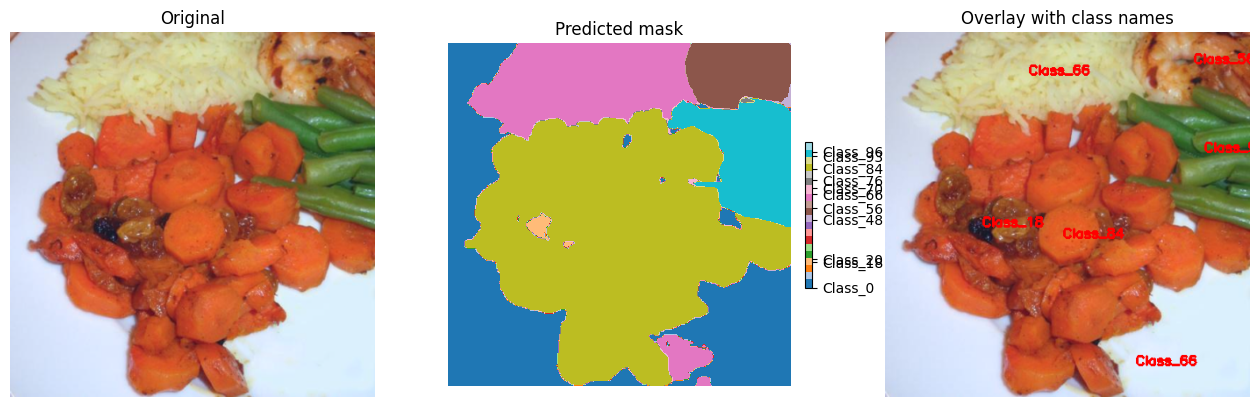

In [19]:
# Build class_names list (replace with real labels if you have classes.txt)
class_names = [f"Class_{i}" for i in range(NUM_CLASSES)]

@torch.no_grad()
def visualize_sample(write_labels=True):
    model.eval()
    images, masks = next(iter(val_loader))
    images = images.to(DEVICE)
    logits = model(images)
    preds = logits.argmax(1).cpu().numpy()
    img_np = images[0].cpu().permute(1,2,0).numpy()
    img_disp = np.clip(img_np * 0.229 + 0.485, 0, 1)  # approx unnormalize for display

    mask_pred = preds[0]
    unique_classes = np.unique(mask_pred)

    # Colorize mask
    cmap = plt.get_cmap("tab20", NUM_CLASSES)

    # Overlay text using contours
    import cv2
    img_plt = (img_disp * 255).astype(np.uint8).copy()

    for c in unique_classes:
        if c == IGNORE_INDEX or c == 0:  # skip background (optional)
            continue
        bin_mask = (mask_pred == c).astype(np.uint8)
        contours, _ = cv2.findContours(bin_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            if cv2.contourArea(cnt) < 200:
                continue
            M = cv2.moments(cnt)
            if M["m00"] > 0:
                cx = int(M["m10"]/M["m00"])
                cy = int(M["m01"]/M["m00"])
                if write_labels:
                    cv2.putText(img_plt, class_names[c], (cx, cy),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)

    # Plot original, mask, and labeled overlay
    fig, ax = plt.subplots(1, 3, figsize=(16,6))
    ax[0].imshow(img_disp)
    ax[0].set_title("Original")
    ax[0].axis("off")

    im = ax[1].imshow(mask_pred, cmap=cmap, vmin=0, vmax=NUM_CLASSES-1)
    ax[1].set_title("Predicted mask")
    ax[1].axis("off")
    cbar = plt.colorbar(im, ax=ax[1], fraction=0.02, pad=0.04)
    # limit ticks to only present classes
    cbar.set_ticks(unique_classes)
    cbar.set_ticklabels([class_names[c] for c in unique_classes])

    ax[2].imshow(img_plt)
    ax[2].set_title("Overlay with class names")
    ax[2].axis("off")
    plt.show()

visualize_sample(write_labels=True)


In [21]:
# لو كنت خلصت 25 إبوك
last_epoch = 25
extra_epochs = 25

for epoch in range(last_epoch+1, last_epoch+extra_epochs+1):
    train_loss, train_miou = train_one_epoch(epoch)
    val_loss, val_miou = validate()

    history["train_loss"].append(train_loss)
    history["train_miou"].append(train_miou)
    history["val_loss"].append(val_loss)
    history["val_miou"].append(val_miou)

    print(f"\nEpoch {epoch}")
    print(f"Train → Loss: {train_loss:.4f} | mIoU: {train_miou:.4f}")
    print(f"Val   → Loss: {val_loss:.4f} | mIoU: {val_miou:.4f}")

    if val_miou > best_miou:
        best_miou = val_miou
        torch.save({
            "model": model.state_dict(),
            "miou": best_miou,
            "epoch": epoch
        }, SAVE_BEST_PATH)
        print(f"✓ Best model saved at {SAVE_BEST_PATH} (mIoU: {best_miou:.4f})")


Epoch 26 [train]:   0%|          | 0/623 [00:00<?, ?it/s]/tmp/ipykernel_47/2032673120.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validate: 100%|██████████| 134/134 [00:32<00:00,  4.18it/s]



Epoch 26
Train → Loss: 0.2955 | mIoU: 0.3934
Val   → Loss: 1.1675 | mIoU: 0.2431
✓ Best model saved at best_deeplabv3plus_mobilenetv2.pth (mIoU: 0.2431)


Validate: 100%|██████████| 134/134 [00:32<00:00,  4.18it/s]



Epoch 27
Train → Loss: 0.2830 | mIoU: 0.3976
Val   → Loss: 1.1853 | mIoU: 0.2390


Validate: 100%|██████████| 134/134 [00:31<00:00,  4.19it/s]



Epoch 28
Train → Loss: 0.2670 | mIoU: 0.4126
Val   → Loss: 1.1792 | mIoU: 0.2401


Validate: 100%|██████████| 134/134 [00:32<00:00,  4.18it/s]



Epoch 29
Train → Loss: 0.2547 | mIoU: 0.4212
Val   → Loss: 1.2106 | mIoU: 0.2403


Validate: 100%|██████████| 134/134 [00:31<00:00,  4.19it/s]



Epoch 30
Train → Loss: 0.2415 | mIoU: 0.4317
Val   → Loss: 1.2059 | mIoU: 0.2415


Validate: 100%|██████████| 134/134 [00:31<00:00,  4.20it/s]



Epoch 31
Train → Loss: 0.2321 | mIoU: 0.4405
Val   → Loss: 1.2435 | mIoU: 0.2411


Validate: 100%|██████████| 134/134 [00:31<00:00,  4.20it/s]



Epoch 32
Train → Loss: 0.2210 | mIoU: 0.4511
Val   → Loss: 1.2319 | mIoU: 0.2446
✓ Best model saved at best_deeplabv3plus_mobilenetv2.pth (mIoU: 0.2446)


Validate: 100%|██████████| 134/134 [00:31<00:00,  4.19it/s]



Epoch 33
Train → Loss: 0.2121 | mIoU: 0.4643
Val   → Loss: 1.2188 | mIoU: 0.2372


Validate: 100%|██████████| 134/134 [00:31<00:00,  4.19it/s]



Epoch 34
Train → Loss: 0.2036 | mIoU: 0.4749
Val   → Loss: 1.2323 | mIoU: 0.2421


Validate: 100%|██████████| 134/134 [00:31<00:00,  4.20it/s]



Epoch 35
Train → Loss: 0.1962 | mIoU: 0.4820
Val   → Loss: 1.2422 | mIoU: 0.2414


Validate: 100%|██████████| 134/134 [00:32<00:00,  4.18it/s]



Epoch 36
Train → Loss: 0.1880 | mIoU: 0.4934
Val   → Loss: 1.2431 | mIoU: 0.2438


Validate: 100%|██████████| 134/134 [00:32<00:00,  4.19it/s]



Epoch 37
Train → Loss: 0.1839 | mIoU: 0.4978
Val   → Loss: 1.2566 | mIoU: 0.2425


Validate: 100%|██████████| 134/134 [00:31<00:00,  4.19it/s]



Epoch 38
Train → Loss: 0.1799 | mIoU: 0.5006
Val   → Loss: 1.2609 | mIoU: 0.2401


Validate: 100%|██████████| 134/134 [00:31<00:00,  4.19it/s]



Epoch 39
Train → Loss: 0.1721 | mIoU: 0.5155
Val   → Loss: 1.2523 | mIoU: 0.2396


Validate: 100%|██████████| 134/134 [00:31<00:00,  4.19it/s]



Epoch 40
Train → Loss: 0.1677 | mIoU: 0.5228
Val   → Loss: 1.2646 | mIoU: 0.2396


Validate: 100%|██████████| 134/134 [00:31<00:00,  4.20it/s]



Epoch 41
Train → Loss: 0.1636 | mIoU: 0.5279
Val   → Loss: 1.2483 | mIoU: 0.2468
✓ Best model saved at best_deeplabv3plus_mobilenetv2.pth (mIoU: 0.2468)


Validate: 100%|██████████| 134/134 [00:31<00:00,  4.19it/s]



Epoch 42
Train → Loss: 0.1618 | mIoU: 0.5305
Val   → Loss: 1.2588 | mIoU: 0.2450


Validate: 100%|██████████| 134/134 [00:32<00:00,  4.18it/s]



Epoch 43
Train → Loss: 0.1587 | mIoU: 0.5336
Val   → Loss: 1.2572 | mIoU: 0.2439


Validate: 100%|██████████| 134/134 [00:31<00:00,  4.19it/s]



Epoch 44
Train → Loss: 0.1567 | mIoU: 0.5388
Val   → Loss: 1.2591 | mIoU: 0.2426


Validate: 100%|██████████| 134/134 [00:31<00:00,  4.20it/s]



Epoch 45
Train → Loss: 0.1543 | mIoU: 0.5464
Val   → Loss: 1.2541 | mIoU: 0.2464


Validate: 100%|██████████| 134/134 [00:32<00:00,  4.18it/s]



Epoch 46
Train → Loss: 0.1536 | mIoU: 0.5475
Val   → Loss: 1.2570 | mIoU: 0.2413


Validate: 100%|██████████| 134/134 [00:32<00:00,  4.19it/s]



Epoch 47
Train → Loss: 0.1545 | mIoU: 0.5477
Val   → Loss: 1.2471 | mIoU: 0.2442


Validate: 100%|██████████| 134/134 [00:31<00:00,  4.20it/s]



Epoch 48
Train → Loss: 0.1517 | mIoU: 0.5506
Val   → Loss: 1.2565 | mIoU: 0.2460


Validate: 100%|██████████| 134/134 [00:31<00:00,  4.19it/s]



Epoch 49
Train → Loss: 0.1535 | mIoU: 0.5499
Val   → Loss: 1.2571 | mIoU: 0.2437


Validate: 100%|██████████| 134/134 [00:32<00:00,  4.19it/s]


Epoch 50
Train → Loss: 0.1512 | mIoU: 0.5471
Val   → Loss: 1.2539 | mIoU: 0.2430


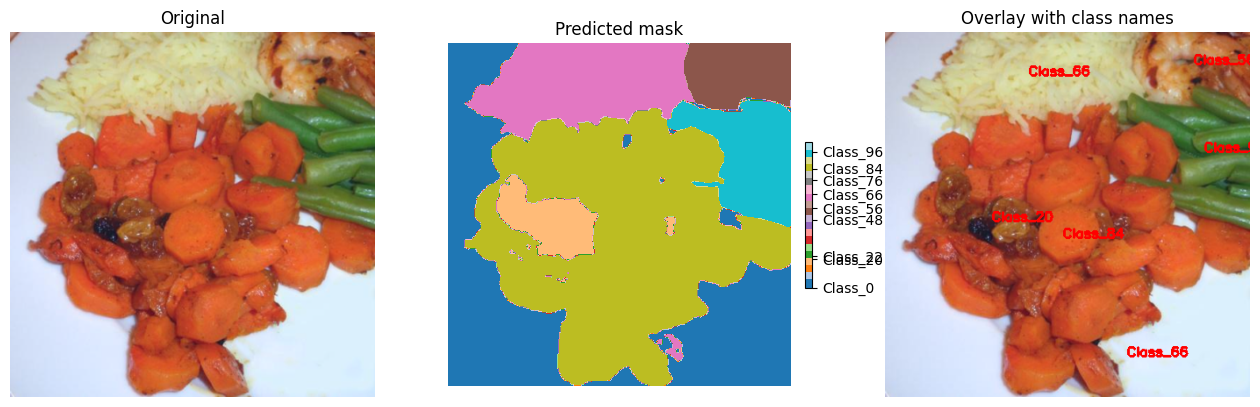

In [22]:
# Build class_names list (replace with real labels if you have classes.txt)
class_names = [f"Class_{i}" for i in range(NUM_CLASSES)]

@torch.no_grad()
def visualize_sample(write_labels=True):
    model.eval()
    images, masks = next(iter(val_loader))
    images = images.to(DEVICE)
    logits = model(images)
    preds = logits.argmax(1).cpu().numpy()
    img_np = images[0].cpu().permute(1,2,0).numpy()
    img_disp = np.clip(img_np * 0.229 + 0.485, 0, 1)  # approx unnormalize for display

    mask_pred = preds[0]
    unique_classes = np.unique(mask_pred)

    # Colorize mask
    cmap = plt.get_cmap("tab20", NUM_CLASSES)

    # Overlay text using contours
    import cv2
    img_plt = (img_disp * 255).astype(np.uint8).copy()

    for c in unique_classes:
        if c == IGNORE_INDEX or c == 0:  # skip background (optional)
            continue
        bin_mask = (mask_pred == c).astype(np.uint8)
        contours, _ = cv2.findContours(bin_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            if cv2.contourArea(cnt) < 200:
                continue
            M = cv2.moments(cnt)
            if M["m00"] > 0:
                cx = int(M["m10"]/M["m00"])
                cy = int(M["m01"]/M["m00"])
                if write_labels:
                    cv2.putText(img_plt, class_names[c], (cx, cy),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)

    # Plot original, mask, and labeled overlay
    fig, ax = plt.subplots(1, 3, figsize=(16,6))
    ax[0].imshow(img_disp)
    ax[0].set_title("Original")
    ax[0].axis("off")

    im = ax[1].imshow(mask_pred, cmap=cmap, vmin=0, vmax=NUM_CLASSES-1)
    ax[1].set_title("Predicted mask")
    ax[1].axis("off")
    cbar = plt.colorbar(im, ax=ax[1], fraction=0.02, pad=0.04)
    # limit ticks to only present classes
    cbar.set_ticks(unique_classes)
    cbar.set_ticklabels([class_names[c] for c in unique_classes])

    ax[2].imshow(img_plt)
    ax[2].set_title("Overlay with class names")
    ax[2].axis("off")
    plt.show()

visualize_sample(write_labels=True)
